# Code for project 1 in TMA4212

## Functions

In [49]:
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt
from matplotlib import cm
from numba import jit
import time
from scipy.optimize import fsolve

%matplotlib inline

In [60]:
def nada(x, t, a=1, b=1, c=1):#a, b, c is not used but neede to ensure compatibility and generelity of the all the RHS-functions
    return 0
nothing = np.vectorize(nada) #Default RHS of the of the equations


In [3]:
#%% Plotting function
def plot_solution(x, t, U, txt='Solution', azim=50):
    # Plot the solution of the equation. This function was given in exercise 2
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    T, X = np.meshgrid(t,x)
    # ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=azim)              # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt)
    plt.show()


In [4]:
#%% Initial condition functions
def European(x, K, H):
    return max(K - x, 0)
def Butterfly(x, K, H):
    return max(0, x - K) - 2*max(0, x-K-H) + max(0,x-K-2*H)
def Binary(x, K, H):
    return max(0, np.sign(x - K))

#vectorize functions to ensure numpy compatibility
Euro = np.vectorize(European)
Butter = np.vectorize(Butterfly)
Bin = np.vectorize(Binary)



In [5]:
#%% Forward Euler, Boundary condition 1
@jit
def FEBC1(R, T, M, N, sigSq, r, c, K, H, f0, RHS=nothing):
    '''
    solving BS with FE and BC1
    ------
    R: x-boundary
    T: end-time
    M: # of internal nodes
    N: # of time steps
    sigSq: volatility
    r: interest rate
    c: dividends
    f0: function for calculating initial condition
    RHS: right hand side of equation
    '''
    h = R/(M+1) #step length in space
    k = T/N #step length in time
    x = np.arange(0, R+0.5*h, h) #space-points, including end points
    t = np.arange(0, T+0.5*k, k) #time points, including end points
    
    U0 = f0(x, K, H) #initial condition
    
    n = np.arange(0,N+1,1)#vector with time indexes
    m = np.arange(0, M + 2, 1) #vector of where m[j] = (j+1)
    mSq = m**2  #vector of where mSq[j] = (j+1)^2
    
    lower = 0.5*( k*sigSq*mSq - k*r*m) #lower diagonal in A
    diag = -k*sigSq*mSq - k*c #diagonal in A
    upper = 0.5*( k*sigSq*mSq + k*r*m)#upper diagonal in A
    
    P = diags([lower[2:-1], diag[1:-1], upper[1:-2]], [-1,0,1])
    A = np.identity(M) + P #iteration matrix
        
    U = np.zeros((M+2, N+1)) 
    U[:,0] = U0
    U[0] = U0[0]*np.exp(-c*k*n) #setting BC
    U[-1] = U0[-1]*np.ones(N+1)

    for i in range(1, N+1):
        b = k*RHS(x[1:-1], t[i-1], sigSq, r, c)#make right side of function
        b[0] = b[0] + U0[0]*np.exp(-c*k*(i-1))*0.5*(k*sigSq - k*r) #add boundary condition at x = 0
        b[-1] = b[-1] + U0[-1]*0.5*(k*sigSq*M**2 + k*r*M)   #add boundary condition at x = R
        
        U[1:-1,i] = A.dot(U[1:-1, i-1]) + b
    
    return x, t, U

In [6]:
#%% Backwards Euler, boundary condition 1
@jit
def BEBC1(R, T, M, N, sigSq, r, c, K, H, f0, RHS=nothing):
    '''
    solving BS with BE and BC1
    ------
    R: x-boundary
    T: end-time
    M: # of internal nodes
    N: # of time steps
    sigSq: volatility
    r: interest rate
    c: dividends
    f0: function for calculating initial condition
    RHS: right hand side of equation
    '''
    h = R/(M+1) #step length in space
    k = T/N #step length in time
    x = np.arange(0, R+0.5*h, h) #space-points, including end points
    t = np.arange(0, T+0.5*k, k) #time points, including end points
    
    U0 = f0(x, K, H) #initial condition
    
    n = np.arange(0,N+1,1)#vector with time indexes
    m = np.arange(0, M + 2, 1) #vector of where m[j] = (j)
    mSq = m**2  #vector of where mSq[j] = (j)^2
    
    lower = 0.5*( -k*sigSq*mSq + k*r*m) #lower diagonal in A
    diag = k*sigSq*mSq + k*c #diagonal in A
    upper = 0.5*( -k*sigSq*mSq - k*r*m)#upper diagonal in A
    
    P = diags([lower[2:-1], diag[1:-1], upper[1:-2]], [-1,0,1])
    A = np.identity(M) + P #iteration matrix
    
    
    U = np.zeros((M+2, N+1)) 
    U[:,0] = U0     #setting initial condition
    U[0] = U0[0]*np.exp(-c*k*n)#setting BC at x = 0
    U[-1] = U0[-1]*np.ones(N+1)#setting BC at x = R

    for i in range(1, N+1):
        b = k*RHS(x[1:-1], t[i], sigSq, r, c) #make b for modified right hand side
        b[0] = b[0] + U0[0]*np.exp(-c*k*i)*0.5*(k*sigSq - k*r)  #add boundary conditions x = 0
        b[-1] = b[-1] + U0[-1]*0.5*(k*sigSq*M**2 + k*r*M)   #add boundary condition at x = R
        
        U[1:-1,i] = np.linalg.solve(A, U[1:-1, i-1] + b )
    
    return x, t, U


In [7]:
#%% CN BC1
@jit
def AllBC1(R, T, M, N, sigSq, r, c, K, H, f0, method=2, RHS=nothing):
    '''
    solving BS with CN and BC1
    This function is implemented as a theta-method, so it can solve with FE, BE and CN (standard)
    ------
    R: x-boundary
    T: end-time
    M: # of internal nodes
    N: # of time steps
    sigSq: volatility
    r: interest rate
    c: dividends
    f0: function for calculating initial condition
    method: which method to use. 0:FE, 1: BE, 2:CN
    '''
    thetas = [[0,0.5], [0.5, 0], [0.25, 0.25]]
    theta = thetas[method]
    
    h = R/(M+1) #step length in space
    k = T/N #step length in time
    x = np.arange(0, R+0.5*h, h) #space-points, including end points
    t = np.arange(0, T+0.5*k, k) #time points, including end points
    
    U0 = f0(x, K, H) #initial condition
    
    n = np.arange(0,N+1,1)#vector with time indexes
    m = np.arange(0, M + 2, 1) #vector of where m[j] = (j+1)
    mSq = m**2  #vector of where mSq[j] = (j+1)^2
    
    lower = ( k*sigSq*mSq - k*r*m) #lower diagonal in A
    diag = -2*k*sigSq*mSq -2*k*c #diagonal in A
    upper = ( k*sigSq*mSq + k*r*m)#upper diagonal in A
    
    P = diags([lower[2:-1], diag[1:-1], upper[1:-2]], [-1,0,1])
    A1 = np.identity(M) - theta[0]*P #iteration matrices
    A2 = np.identity(M) + theta[1]*P
    
    
    U = np.zeros((M+2, N+1)) 
    U[:,0] = U0         #setting initial condition
    U[0] = U0[0]*np.exp(-c*k*n)#setting BC at x = 0
    U[-1] = U0[-1]*np.ones(N+1) #setting BC at x = R

    for i in range(1, N+1):
        b = k*2*( theta[0]*RHS(x[1:-1], t[i], sigSq, r, c) + theta[1]*RHS(x[1:-1], t[i-1], sigSq, r, c) ) #making right hand side
        b[0] = b[0] + U0[0]*( theta[0]*np.exp(-c*k*i) + theta[1]*np.exp(-c*k*(i-1) ))*(lower[1]) #BC at x 0 =
        b[-1] = b[-1] + U0[-1]*0.5*(upper[M])   #BC at x = R
        
        U[1:-1,i] = np.linalg.solve(A1, A2.dot( U[1:-1, i-1] ).A1 + b ) #.A1 is to convert from matrix to vector
    
    return x, t, U


In [8]:
#%% FE BC2
#implementation with boundary condition #2
@jit
def FEBC2(R, T, M, N, sigSq, r, c, K, H, f0, RHS=nothing):
    '''
    solving BS with FE and BC2
    ------
    R: x-boundary
    T: end-time
    M: # of internal nodes
    N: # of time steps
    sigSq: volatility
    r: interest rate
    c: dividends
    f0: function for calculating initial condition
    RHS: right hand side of equation
    '''
    h = R/(M+1) #step length in space
    k = T/N #step length in time
    x = np.arange(0, R+1.5*h, h) #space-points, including x_M+2
    t = np.arange(0, T+0.5*k, k) #time points, including end points
    
    U0 = f0(x, K, H) #initial condition
    
    n = np.arange(0,N+1,1)#vector with time indexes
    m = np.arange(0, M + 3, 1) #vector where m[j] = j, last element is (M+2)
    mSq = m**2  #vector of where mSq[j] = (j)^2
    
    lower = 0.5*( k*sigSq*mSq - k*r*m) #lower diagonal in P    
    diag = -k*sigSq*mSq - k*c #diagonal in A
    upper = 0.5*( k*sigSq*mSq + k*r*m)#upper diagonal in P
    
    lower[-2] = lower[-2] + upper[-2] #Change what will be the last sub-diagonal element
    
    P = diags([lower[2:-1], diag[1:-1], upper[1:-2]], [-1,0,1])
    A = np.identity(M + 1) + P #iteration matrix
    
    B = np.zeros((M + 1, N + 1)) #matrix with modified BC's to use as b^n
    
    DxR = ( U0[-1] - U0[-3] )/(2*h)

    U = np.zeros((M+2, N+1)) 
    U[:,0] = U0[:-1]
    U[0] = U0[0]*np.exp(-c*k*n) #setting BC


    for i in range(1, N+1):
        b = k*RHS(x[1:], t[i-1], sigSq, r, c)#make right side of function
        b[0] = b[0] + U0[0]*np.exp(-c*k*(i-1))*0.5*(k*sigSq - k*r)  #BC at x = 0
        b[-1] = b[-1] + h*DxR*(k*sigSq*(M+1)**2 + k*r*(M+1))        #BC at x = R
        
        U[1:,i] = A.dot(U[1:, i-1]) + B[:,i-1]
    
    return x[:-1], t, U


In [9]:
#%% BE BC2
#Backwards Euler with BC2
@jit
def BEBC2(R, T, M, N, sigSq, r, c, K, H, f0, RHS=nothing):
    '''
    solving BS with BE and the second boundary condition (BC2)
    ------
    R: x-boundary
    T: end-time
    M: # of internal nodes
    N: # of time steps
    sigSq: volatility
    r: interest rate
    c: dividends
    f0: function for calculating initial condition
    RHS: right hand side of equation
    '''
    h = R/(M+1) #step length in space
    k = T/N #step length in time
    x = np.arange(0, R+1.5*h, h) #space-points, including x_M+2
    t = np.arange(0, T+0.5*k, k) #time points, including end points
    
    U0 = f0(x, K, H) #initial condition
    DxR = ( U0[-1] - U0[-3] )/(2*h) #aproximating the derivative for the BC
    
    n = np.arange(0,N+1,1)#vector with time indexes
    m = np.arange(0, M + 3, 1) #vector of where m[j] = (j), last element is M+2
    mSq = m**2  #vector of where mSq[j] = (j)^2
    
    lower = 0.5*( -k*sigSq*mSq + k*r*m) #lower diagonal in A
    diag = k*sigSq*mSq + k*c #diagonal in A
    upper = 0.5*( -k*sigSq*mSq - k*r*m)#upper diagonal in A
    
    lower[-2] = lower[-2] + upper[-2] #Change what will be the last sub-diagonal element
    
    P = diags([lower[2:-1], diag[1:-1], upper[1:-2]], [-1,0,1])
    A = np.identity(M+1) + P #iteration matrix
    
    
    U = np.zeros((M+2, N+1)) #allocating space for the solution
    U[:,0] = U0[:-1] #setting IC
    U[0] = U0[0]*np.exp(-c*k*n)#calculating BC
    
    for i in range(1, N+1):
        b = k*RHS(x[1:-1], t[i], sigSq, r, c)#make right side of function
        b[0] = b[0] + U0[0]*np.exp(-c*k*(i))*0.5*(k*sigSq - k*r) #setting BC at x = 0
        b[-1] = b[-1] + h*DxR*(k*sigSq*(M+1)**2 + k*r*(M+1)) #setting BC at x = R
        
        
        U[1:,i] = np.linalg.solve(A, U[1:, i-1] + b )
    
    return x[:-1], t, U


In [10]:
#%% CN with BC2
@jit
def AllBC2(R, T, M, N, sigSq, r, c, K, H, f0, method=2, RHS=nothing):
    '''
    solving BS with CE and BC2. Can be adapted to solve as FE and BE
    ------
    R: x-boundary
    T: end-time
    M: # of internal nodes
    N: # of time steps
    sigSq: volatility
    r: interest rate
    c: dividends
    f0: function for calculating initial condition
    method: which method to use. 0:FE, 1: BE, 2:CN
    RHS: right hand side of equation
    '''
    thetas = [[0,0.5], [0.5, 0], [0.25, 0.25]]
    theta = thetas[method]
    
    h = R/(M+1) #step length in space
    k = T/N #step length in time
    x = np.arange(0, R+1.5*h, h) #space-points, including end points
    t = np.arange(0, T+0.5*k, k) #time points, including end points
    
    U0 = f0(x, K, H) #initial condition
    DxR = ( U0[-1] - U0[-3] )/(2*h)
    
    n = np.arange(0,N+1,1)#vector with time indexes
    m = np.arange(0, M + 3, 1) #vector of where m[j] = (j)
    mSq = m**2  #vector of where mSq[j] = (j)^2
    
    lower = ( k*sigSq*mSq - k*r*m) #lower diagonal in A
    diag = -2*k*sigSq*mSq -2*k*c #diagonal in A
    upper = ( k*sigSq*mSq + k*r*m)#upper diagonal in A
    
    lower[-2] = lower[-2] + upper[-2] #Change what will be the last sub-diagonal element
    
    P = diags([lower[2:-1], diag[1:-1], upper[1:-2]], [-1,0,1])
    A1 = np.identity(M+1) - theta[0]*P #iteration matrices
    A2 = np.identity(M+1) + theta[1]*P
    
    B = np.zeros((M+1, N + 1)) #matrix with modified BC's to use as b^n+1
    
    B[0] = U0[0]*( theta[0]*np.exp(-c*k*n) + theta[1]*np.exp(-c*k*(n-1) ))*(lower[1])
    B[-1] = h*DxR*np.ones(N+1)*(upper[M+1])
    
    U = np.zeros((M+2, N+1)) 
    U[:,0] = U0[:-1]
    U[0] = U0[0]*np.exp(-c*k*n)#setting BC


    for i in range(1, N+1):
        b = k*2*( theta[0]*RHS(x[1:-1], t[i], sigSq, r, c) + theta[1]*RHS(x[1:-1], t[i-1], sigSq, r, c) ) #setting RHS
        b[0] = b[0] + U0[0]*( theta[0]*np.exp(-c*k*i) + theta[1]*np.exp(-c*k*(i-1) ))*(lower[1])    #setting BC at x = 0
        b[-1] = b[-1] + h*DxR*(upper[M+1])#setting BC at x = R 
        
        U[1:,i] = np.linalg.solve(A1, A2.dot( U[1:, i-1] ).A1 + b ) #.A1 is to convert from matrix to vector
    
    return x[:-1], t, U


In [11]:
#%% IMEX with BC1

def Phi(x):
    """
    Phi function in the nonlinear BS-equation
    """
    return sig1Sq + (sig2Sq - sig1Sq)/2 * (1 + 2/np.pi * np.arctan(x))

@jit
def IMEXBC1(R, T, M, N, sig1Sq, sig2Sq, c, K, H, f0, RHS=nothing):
    '''
    solving BS with IMEX and BC1
    ------
    R: x-boundary
    T: end-time
    M: # of internal nodes
    N: # of time steps
    sig1Sq: volatility
    sig2Sq: volatility
    K, H: Strike prices
    f0: function for calculating initial condition
    RHS: right hand side function
    '''
    h = R/(M+1) #step length in space
    k = T/N #step length in time
    x = np.arange(0, R+0.5*h, h) #space-points, including end points
    t = np.arange(0, T+0.5*k, k) #time points, including end points
    
    U0 = f0(x, K, H)#initial condition
    UR = U0[-1]
    
    n = np.arange(0,N+1,1)#vector with time indexes
    m = np.arange(0, M + 2, 1) #vector of where m[j] = (j), last element is M+1
    mSq = m**2  #vector of where mSq[j] = (j)^2
    
    long1 = np.ones(M+2)
    F = 1/h**2 * diags([long1[1:], -2*long1, long1[:-1]],[-1,0,1])
    
    U = np.zeros((M+2, N+1)) 
    U[:,0] = U0
    U[0] = U0[0]*np.ones(N+1)#setting BC at x = 0
    U[-1] = UR*np.ones(N+1)#setting BC at x = R
    
    

    Id = np.identity(M)
    for i in range(1, N+1):
        phi = Phi(F.dot(U[:, i-1]))

        b = k*RHS(x[1:-1], t[i], 1,1,1)#should be M x 1
        b[0] = b[0] + k/2 * phi[1] * U[0, i]
        b[-1] = b[-1] + k/2 * M**2 * phi[M] * UR
        
        diagVec = k/2 * np.multiply(mSq, phi)
        
        Q = diags( [diagVec[2:-1], -2*diagVec[1:-1], diagVec[1:-2]] , [-1,0,1])
        
        
        U[1:-1,i] = np.linalg.solve(Id - Q, U[1:-1, i-1] + b )
    
    return x, t, U
    

In [62]:
@jit
def sys(u, bc1, bc2, x, t, i, uPrev, mSq, F, RHS, k, h):
    '''
    function for the nonlinear system to solve in BENL
    '''
    l = len(u)
    uExt = np.zeros(l+2) #make an extended version of u, to use with F
    uExt[0] = bc1
    uExt[-1] = bc2
    uExt[1:-1] = u
    
    mSqPhi = np.multiply(mSq[1:-1], Phi(F.dot(uExt)[1:-1]))
    
    return u - uPrev- k*0.5*h**2 * np.multiply(mSqPhi, F.dot(uExt)[1:-1]) - k*RHS(x[1:-1], t[i], 1, 1, 1)
@jit
def BENLBC1(R, T, M, N, sig1Sq, sig2Sq, c, K, H, f0, RHS=nothing):
    '''
    solving BS with IMEX and BC1
    ------
    R: x-boundary
    T: end-time
    M: # of internal nodes
    N: # of time steps
    sig1Sq: volatility
    sig2Sq: volatility
    K, H: Strike prices
    f0: function for calculating initial condition
    RHS: right hand side function
    '''
    h = R/(M+1) #step length in space
    k = T/N #step length in time
    x = np.arange(0, R+0.5*h, h) #space-points, including end points
    t = np.arange(0, T+0.5*k, k) #time points, including end points
    
    U0 = f0(x, K, H)#initial condition
    UR = U0[-1]
    
    n = np.arange(0,N+1,1)#vector with time indexes
    m = np.arange(0, M + 2, 1) #vector of where m[j] = (j), last element is M+1
    mSq = m**2  #vector of where mSq[j] = (j)^2
    
    long1 = np.ones(M+2)
    F = 1/h**2 * diags([long1[1:], -2*long1, long1[:-1]],[-1,0,1])
    
    U = np.zeros((M+2, N+1)) 
    U[:,0] = U0
    U[0] = U0[0]*np.ones(N+1)#setting BC at x = 0
    U[-1] = UR*np.ones(N+1)#setting BC at x = R
    
    
    for i in range(1, N+1):
        bc1 = U[0,i]
        bc2 = U[-1,i]
        U[1:-1,i] = fsolve(sys, U[1:-1, i-1], args=(bc1, bc2, x, t, i, U[1:-1, i-1], mSq, F, RHS, k, h) )
    
    return x, t, U 

In [57]:
#%% Funcs for exact solution
@jit
def exact(x, t):
    return 5*np.sin(np.pi * (x-20)/20)*np.cos(np.pi/20 * t)
@jit
def exactInit(x, K, H):
    #return the value of the exact solution at t = 0
    return exact(x, 0)

@jit
def ux(x, t):
    #first spatial derivative of the exact solution
    return 5*np.pi/20 * np.cos(np.pi * (x-20)/20)*np.cos(np.pi/20 * t)
@jit
def uxx(x, t):#second space derivative of the exact solution
    return ( -5*np.pi**2 /(20**2) * np.sin( np.pi * (x-20)/20 )*np.cos(np.pi/20 * t) )

@jit            
def ut(x, t):
    #time derivative of exact solution
    return -5*np.pi/20 * np.sin(np.pi * (x-20)/20)*np.sin(np.pi/20 * t)
@jit
def exRHS(x, t, a=1, b=1, c=1):#a, b, c are dummy variables and will not be used, but is included to ensure compatibility and generality
    #the right hand side in the nonlinear case
    return ut(x, t) - 0.5*np.multiply(x, x)*Phi(uxx(x,t))*uxx(x,t)
@jit
def exRHSLin(x, t, sigSq, r, c):
    #the right hand side in the linear case
    return ut(x, t) - 0.5*sigSq*x**2*uxx(x, t) - r*x*ux(x, t) + c*exact(x, t)
@jit
def getEx(x, t, M, N):
    #calculates the exact solution on the grid given by x and t
    ex = np.zeros((M+2, N + 1))
    for i in range(M + 2):
        for j in range(N + 1):
            ex[i, j] = exact(x[i], t[j])

    return ex


In [14]:
#%% Error analysis function
@jit
def errorAnalysisNonLin(solver, R, T, M, N, sig1Sq, sig2Sq, c, K, H, f0, RHS=nothing, Nstart=10, Nstop=500, Nstep = 10
                      , Mstart=10, Mstop=300, Mstep=10, Nst=100, Mst=50):
    """
    Does error analysis by varying M, N when N, M is constant
    
    Nstart, Nstop: start, stop values when M is constant
    Mstart, Mstop: start, stop values when N is constant
    Nstep: step size in N when varying N
    Mstep: step size in M when varying M
    Mst: fixed value for M when N varies
    Nst: fixed value for N when M varies
    """
    
    Ns = np.arange(Nstart, Nstop + 1, Nstep)
    Ms = np.arange(Mstart, Mstop + 1, Mstep)
    
    Em = np.zeros(len(Ms)) #errors with N constant
    En = np.zeros(len(Ns)) #errors with M constant
    
    #first: N constant
    for i, M in enumerate(Ms):
        x, t, U = solver(R, T, M, Nst, sig1Sq, sig2Sq, c, K, H, f0, RHS) #  
        Uex1 = getEx(x, t, M, Nst)
        Em[i] = np.abs(U - Uex1).max()
        
    #now: M constant
    for i, N in enumerate(Ns):
        x, t, U = solver(R, T, Mst, N, sig1Sq, sig2Sq, c, K, H, f0, RHS)
        Uex1 = getEx(x, t, Mst, N)
        En[i] = np.abs(U - Uex1).max()
    
    #plt.plot(Ms, np.log(Em))
    plt.loglog(Ms, Em)
    plt.title(f"IMEX Error a.f.o. M, N = {Nst}")
    plt.xlabel("M")
    plt.ylabel("Error, maxnorm")
    plt.show()
    
    plt.loglog(Ns, En)
    plt.title(f"IMEX Error a.f.o. N, M = {Mst}")
    plt.xlabel("N")
    plt.ylabel("Error, maxnorm")
    plt.show()
    
    logErrn = np.log(En)
    logErrm = np.log(Em)
    logNs = np.log(Ns)
    logMs = np.log(Ms)
    
    pn = (logErrn[-1]-logErrn[0])/(logNs[-1] - logNs[0])
    print(f"Slope when N varies: {pn}")
    pm = (logErrm[-1]-logErrm[0])/(logMs[-1] - logMs[0])
    print(f"Slope when M varies: {pm}")
    
@jit
def errorAnalysisLin(solver, R, T, sigSq, r, c, K, H, f0, RHS=nothing, Nstart=10, Nstop=500, Nstep = 10
                      , Mstart=10, Mstop=300, Mstep=10, Nst=100, Mst=50, txt=""):
    """
    Does error analysis for solvers for the linear problem.
    Does the analysis by varying M, N when N, M is constant
    
    Nstart, Nstop: start, stop values when M is constant
    Mstart, Mstop: start, stop values when N is constant
    Nstep: step size in N when varying N
    Mstep: step size in M when varying M
    Nst: fixed value for N when M varies
    Mst: fixed value for M when N varies
    txt: text to include in the plot titles. should indicate which method is used
    """
    
    Ns = np.arange(Nstart, Nstop + 1, Nstep)
    Ms = np.arange(Mstart, Mstop + 1, Mstep)
    
    Em = np.zeros(len(Ms)) #errors with N constant
    En = np.zeros(len(Ns)) #errors with M constant
    
    #first: N constant
    for i, M in enumerate(Ms):
        x, t, U = solver(R, T, M, Nst, sigSq, r, c, K, H, f0, RHS=RHS)
        Uex1 = getEx(x, t, M, Nst)
        Em[i] = np.abs(U - Uex1).max()
        
    #now: M constant
    for i, N in enumerate(Ns):
        x, t, U = solver(R, T, Mst, N, sigSq, r, c, K, H, f0, RHS=RHS)
        Uex1 = getEx(x, t, Mst, N)
        En[i] = np.abs(U - Uex1).max()
    
    #plt.plot(Ms, np.log(Em))
    plt.loglog(Ms, Em)
    plt.title(f"{txt} Error a.f.o. M, N = {Nst}")
    plt.xlabel("M")
    plt.ylabel("Max Error")
    plt.show()
    
    plt.loglog(Ns, En)
    plt.title(f"{txt} Error a.f.o. N, M = {Mst}")
    plt.xlabel("N")
    plt.ylabel("Max Error")
    plt.show()
    
    logErrn = np.log(En)
    logErrm = np.log(Em)
    logNs = np.log(Ns)
    logMs = np.log(Ms)

    pn = (logErrn[-1]-logErrn[0])/(logNs[-1] - logNs[0])
    print(f"Slope when N varies: {pn}")
    pm = (logErrm[-1]-logErrm[0])/(logMs[-1] - logMs[0])
    print(f"Slope when M varies: {pm}")


In [15]:
#%%1f) Test effect of ranging R>2K for FE, using CN as exact solution
"""
By experimentation with the exact solution, we found that the error of CN with M 100 times higher than for FE
, the error for CN was 0.01% the error of FE. SO here we treat a high resolution solution with CN as the exact solution.
"""


def fError1(Rstart, Rend, fac, IC):
    """
    Rstart: R value to start at
    Rend: R value to end at
    
    fac: factor specifying how much higher x-resolution should be for CN than for FE
    IC: initial condition function
    """
        
    Rs = np.arange(Rstart, Rend+1, 2)
    errors = np.zeros(len(Rs))
    
    for i, R in enumerate(Rs):
        #print(f"R: {R}")
        M = int(R/2)-1
        N = M**2 #this gets close to CFL-minimum
        
        h = R/(M+1) #shoule\d be 2
        
        Mat2K = int(np.floor(2*K/h)) #the index of the boundary of the region of interest
        
        t1 = time.time()
        x, t, U = FEBC1(R, T, M, N, sigSq, r, c, K, H, IC)
        dt = time.time() - t1
        #plot_solution(x, t, U)
        #print(f"FE time: {dt}")
        
        Uredux = U[:Mat2K+1, :]#filter out everything outside the are of interest
        xredux = x[:Mat2K+1]
        

        M = fac*(M+1) - 1
        
        t1 = time.time()
        xCN, tCN, UCN = AllBC1(R, T, M, N, sigSq, r, c, K, H, IC) #solve with CN with higher resolution
        dt = time.time() - t1
        #print(f"CN time: {dt}" )
        #plot_solution(xCN, tCN, UCN)
        
        UCNRedux = UCN[:fac*Mat2K+1:fac, :]#filter out everythinh outside the region of interest, and reduce resolution.
        xCNredux = xCN[:fac*Mat2K+1:fac]
        
        apxError = Uredux - UCNRedux #caclulate approximated error
        errors[i] = np.abs(apxError).max()
        
    plt.plot(Rs, errors)
    plt.title(f"Max error in x<2K, Res.factor: {fac}")
    plt.xlabel("R")
    plt.ylabel("Max Error")
    plt.show()


@jit
def fError2(Rstart, Rend, fac, IC):
    """
    Solves BS with FE and CN, where the CN-solver has higher spatial 
    resolution than FE. The CN solution is used as exact to estimate the error 
    from FE.

    ------
    Rstart: R value to start at
    Rend: R value to end at
    
    fac: factor specifying how much higher x-resolution should be for CN than for FE
    IC: initial condition function
    """
        
    Rs = np.arange(Rstart, Rend+1, 2)
    errors = np.zeros(len(Rs))
    
    for i, R in enumerate(Rs):
        #print(f"R: {R}")
        M = int(R/2)-1 #keeps h always equal to 2
        N = M**2 #this gets close to CFL-min
        
        h = R/(M+1)
        
        Mat2K = int(np.floor(2*K/h)) 
        
        t1 = time.time()
        x, t, U = FEBC2(R, T, M, N, sigSq, r, c, K, H, IC)
        dt = time.time() - t1
        #plot_solution(x, t, U)
        #print(f"FE time: {dt}")
        
        Uredux = U[:Mat2K+1, :]
        xredux = x[:Mat2K+1]
        

        M = fac*(M+1) - 1
        
        t1 = time.time()
        xCN, tCN, UCN = AllBC2(R, T, M, N, sigSq, r, c, K, H, IC)
        dt = time.time() - t1
        #print(f"CN time: {dt}" )
        #plot_solution(xCN, tCN, UCN)
        
        UCNRedux = UCN[:fac*Mat2K+1:fac, :]
        xCNredux = xCN[:fac*Mat2K+1:fac]
        
        apxError = Uredux - UCNRedux
        errors[i] = np.abs(apxError).max()
        
    plt.plot(Rs, errors)
    plt.title(f"Max error in x<2K, Res.factor: {fac}")
    plt.xlabel("R")
    plt.ylabel("Max Error")
    plt.show()


## Testing

In [16]:
#%%Params, these parameters will be used under most of the testing


def resetParams():
    global R, T, M, N, sigSq, r, c, K, H, sig1Sq, sig2Sq
    R = 80
    T = 10
    M = 50
    N = 700
    sigSq = 0.1
    r = 0.03
    c = 0.05
    K = 20
    H = 8

    sig1Sq = 0.01
    sig2Sq = 0.1

resetParams()

Elapsed time:0.039760589599609375


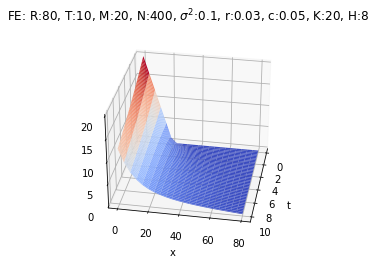

In [19]:
#1a)
#Testing FE with BC1, and IC1

M = 20
N = 400

IC = Euro
tF1 = time.time()
xF, tF, UF = FEBC1(R, T, M, N, sigSq, r, c, K, H, IC)
dtF = time.time()- tF1


print(f"Elapsed time:{dtF}")
paramtext = f"R:{R}, T:{T}, M:{M}, N:{N}, $\sigma ^2$:{sigSq}, r:{r}, c:{c}, K:{K}, H:{H}"
az=10
plot_solution(xF, tF, UF, txt="FE: " + paramtext, azim=az)


Elapsed time: 0.10143399238586426


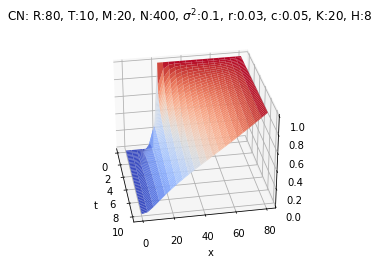

In [21]:
#%%
#Testing with BC1 , IC3: binary

IC = Bin

tCN1 = time.time()
xCN, tCN, UCN = AllBC1(R, T, M, N, sigSq, r, c, K, H, IC, method=2)
dtCN = time.time() - tCN1

print(f"Elapsed time: {dtCN}")
paramtext = f"R:{R}, T:{T}, M:{M}, N:{N}, $\sigma ^2$:{sigSq}, r:{r}, c:{c}, K:{K}, H:{H}"
az = -10
plot_solution(xCN, tCN, UCN, txt="CN: " + paramtext, azim=az)


Elapsed time: BE:0.0615382194519043


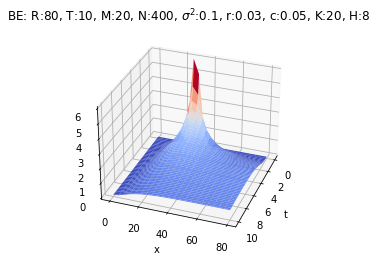

In [23]:
#Testing with BC2, IC2

IC = Butter

tB1 = time.time()
xB, tB, UB = BEBC2(R, T, M, N, sigSq, r, c, K, H, IC)
dtB = time.time() - tB1


print(f"Elapsed time: BE:{dtB}")
paramtext = f"R:{R}, T:{T}, M:{M}, N:{N}, $\sigma ^2$:{sigSq}, r:{r}, c:{c}, K:{K}, H:{H}"
az = 20
plot_solution(xB, tB, UB, txt="BE: " + paramtext, azim=az)


## 1e)

Total t = 0.16326189041137695


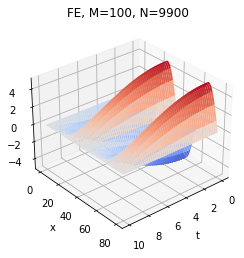

max error: 0.0064350577811760346


<Figure size 432x288 with 0 Axes>

In [26]:
#%%1E FE CFL

M = 100
FEminN = int ( np.ceil( (sigSq*M**2+c)*T ) )
frac = 0.99 
N = int(round(frac*FEminN))


t1 = time.time()
x, t, U = FEBC1(R, T, M, N, sigSq, r, c, K, H, exactInit, RHS = exRHSLin)

 
ex = getEx(x, t, M, N)
print(f"Total t = {time.time() - t1}")

az = 50
plot_solution(x, t, U, txt=f"FE, M={M}, N={N}", azim=az)
#plot_solution(x, t, ex, txt=f"Exact, M={M}, N={N}", azim=az)
plt.savefig("testsave")

error = U - ex
errMax = np.abs(error).max()
#plot_solution(x, t, error, txt=f"FE Error, M={M}, N={N}", azim=az)

print(f"max error: {errMax}")



With M=400: good result when N = 97% of the theoretical minimum value from the CFL-condition, 
breaks down when N = 96% of CFL-cond.
seems like it is stable for lower fractions if M is lower.
at M = 40: good if N=0.88 of CFL-minimum.


Total t = 0.15472197532653809


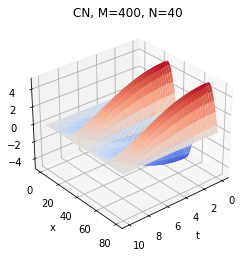

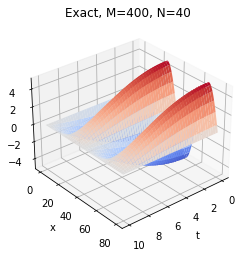

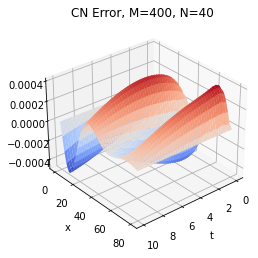

max error: 0.00047962104479902783


In [28]:
#%% 1e) CN CFL

M = 400
CNminN = int ( np.ceil( ( sigSq*M**2+c)*T * 0.5) )
frac = 0.0005
N = int(round(frac*CNminN))

t1 = time.time()
x, t, U = AllBC1(R, T, M, N, sigSq, r, c, K, H, exactInit, RHS = exRHSLin)


ex = getEx(x, t, M, N)
print(f"Total t = {time.time() - t1}")

az = 50
plot_solution(x, t, U, txt=f"CN, M={M}, N={N}", azim=az)
plot_solution(x, t, ex, txt=f"Exact, M={M}, N={N}", azim=az)

error = U - ex
errMax = np.abs(error).max()
plot_solution(x, t, error, txt=f"CN Error, M={M}, N={N}", azim=az)
plt.show()
print(f"max error: {errMax}")
#CN seems to not care about CFL-cond. small error even when N = 0.0005 of the CFL-minimum.


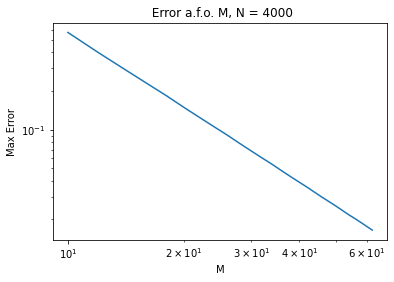

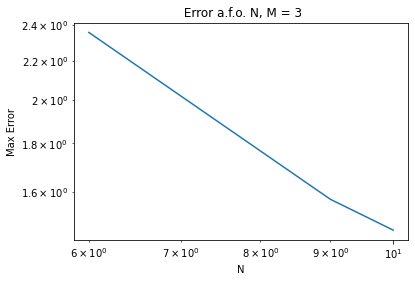

Slope when N varies: -0.9402783326849279
Slope when M varies: -1.9425662209463654


In [30]:
#%%1e) convergense analysis FE
%matplotlib inline
errorAnalysisLin(FEBC1, R, T, sigSq, r, c, K, H, exactInit, RHS=exRHSLin,
                 Mst = 3, Nstart = 6, Nstop=10, Nstep=1,
                 Nst = 4000, Mstart=10, Mstop=62, Mstep=2)
#slope a.f.o. M: -1.94. Semms like order 2 in h
#M=100 very small slope as N varies (-0.002)
#M=3 and N goes from 6 to 10, we get a slope of -0.94. Which suggests a first order dependence w.r.t. k


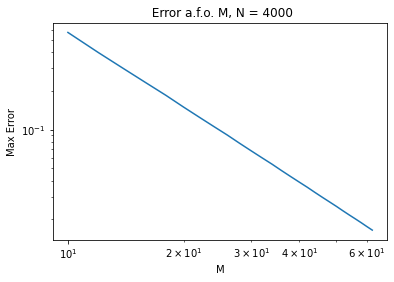

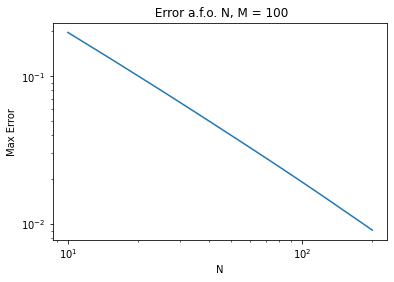

Slope when N varies: -1.0269334225509887
Slope when M varies: -1.9449785486045366


In [32]:
errorAnalysisLin(BEBC1, R, T, sigSq, r, c, K, H, exactInit, RHS=exRHSLin,
                 Mst = 100, Nstart = 10, Nstop=200, Nstep=5,
                 Nst = 4000, Mstart=10, Mstop=62, Mstep=2)

#looks like order 2 with M (h), 
#looks like order 1 with N (k)

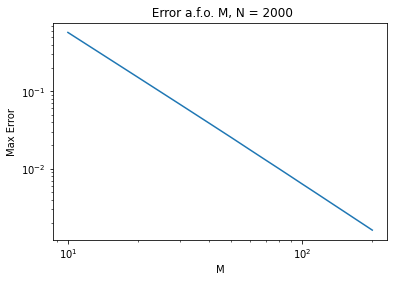

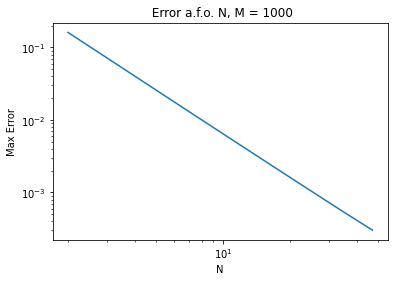

Slope when N varies: -1.9887724225012922
Slope when M varies: -1.9581373886966043


In [34]:
#%% 1e) convergence CN
errorAnalysisLin(AllBC1, R, T, sigSq, r, c, K, H, exactInit, RHS=exRHSLin,
                 Mst = 1000, Nstart = 2, Nstop=50, Nstep=5,
                 Nst = 2000, Mstart=10, Mstop=200, Mstep=10)

#looks like order 2 in both k and h

In the next cell we experiment with M and N to get the error below a arbitrary chosen value of 0.008.

From this experimentation the solution of the three methods was below the error with the following settings for M and N. dt in the data below is the computation time with the given settings.

BE: M=90, N=220, dt = 0.0255
FE: M=90, N=8100, dt=0.0457
CN: M=90, N=30, dt=0.003

Based on this, it looks like CN is approximately 10 times better than BE, which is about twice as fast as FE.

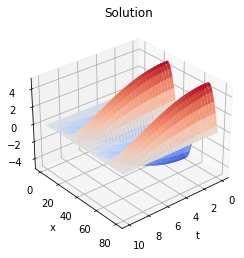

Err:0.00795053561736303 time: 0.0191347599029541


In [36]:
#%%1e) speed given accuracy, V2
# max error: 0.008
resetParams()

M = 90
N = 30

t1 = time.time()
x, t, U = AllBC1(R, T, M, N, sigSq, r, c, K, H, exactInit, RHS = exRHSLin)
dt = time.time() - t1
plot_solution(x, t, U)

ex = getEx(x, t, M, N)
error = U - ex
err = np.abs(error).max()
print(f"Err:{err} time: {dt}")



Here we look at the error for FE in the interval x<2K, as a function of R

By experimentation with the exact solution, we found that the error of CN with M 100 times higher than for FE, the error for CN was 0.01% the error of FE. So here we treat a high resolution solution with CN as the exact solution.

Note that the third argument to te functions below indicate the resolution factor. For the approximated exact solution with CN, we chose this resolution factor to be 5.


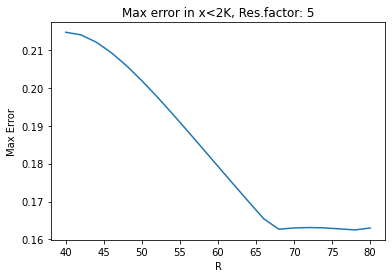

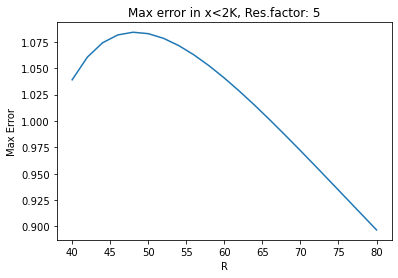

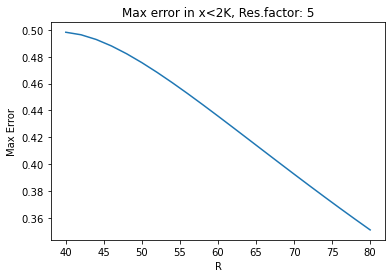

In [38]:

#with BC1
Rstart = 40
Rend = 80
fac = 5

fError1(Rstart, Rend, fac, Euro)

#when IC is Euro, the max error occurs at appx t = 0, and x = K

fError1(Rstart, Rend, fac, Butter)
#with butterfly IC, the error drifts downwards 
fError1(Rstart, Rend, fac, Bin)
#binary, distict downwards trend





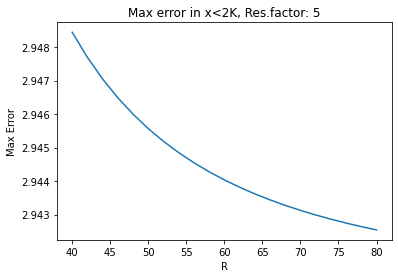

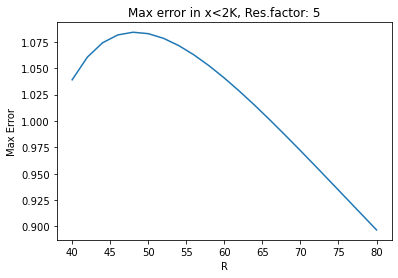

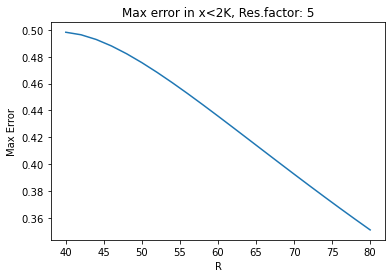

In [41]:
#with BC2
Rstart = 40
Rend = 80
fac = 5

fError2(Rstart, Rend, fac, Euro)
#with euro: error is increasing as R increases. 

fError2(Rstart, Rend, fac, Butter)
#butter: same as with BC1

fError2(Rstart, Rend, fac, Bin)

## 2a) IMEX
Here we solve the nonlinear BS-equation with the IMEX method. 

IMEX elapsed time: 0.32767486572265625


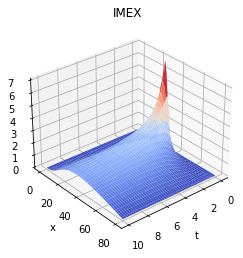

In [43]:
#%% Test of Nonlinear IMEX
resetParams()

tX1 = time.time()
x, t, U = IMEXBC1(R, T, M, N, sig1Sq, sig2Sq, c, K, H, Butter)
dtX = time.time() - tX1

print(f"IMEX elapsed time: {dtX}")
plot_solution(x, t, U, txt="IMEX")

Total t = 0.017920255661010742


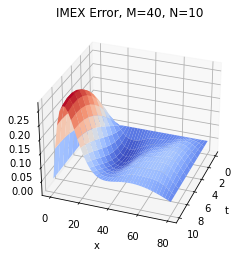

In [45]:
#%% Error testing of IMEX
M = 40
N = 10

t1 = time.time()
x, t, U = IMEXBC1(R, T, M, N, sig1Sq, sig2Sq, c, K, H, exactInit, RHS = exRHS)


ex = getEx(x, t, M, N)
print(f"Total t = {time.time() - t1}")

az = 20
#plot_solution(x, t, U, txt=f"IMEX, M={M}, N={N}", azim=az)
#plot_solution(x, t, ex, txt=f"Exact, M={M}, N={N}", azim=az)

plot_solution(x, t, U - ex, txt=f"IMEX Error, M={M}, N={N}", azim=az)
plt.show()

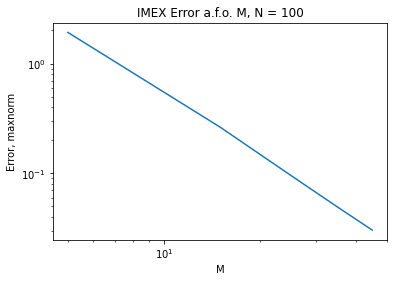

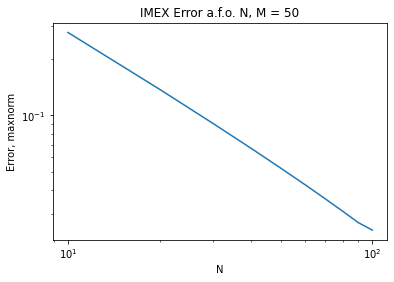

Slope when N varies: -1.0514727692397217
Slope when M varies: -1.8863702604308694


In [47]:
errorAnalysisNonLin(IMEXBC1, R, T, M, N, sig1Sq, sig2Sq, c, K, H, exactInit, RHS=exRHS, Nstart=10, Nstop=100, Nstep = 10
                  ,Mstart=5, Mstop=50)

## 2c) BE-Non-linear

Here we do the same analysis as for IMEX

BENL elapsed time: 0.762885332107544


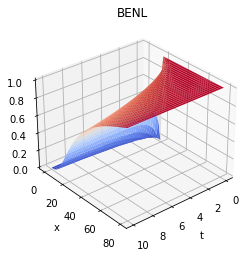

In [65]:
#%% Test of Nonlinear BE
resetParams()

M = 40
N = 40

tX1 = time.time()
x, t, U = BENLBC1(R, T, M, N, sig1Sq, sig2Sq, c, K, H, Bin)
dtX = time.time() - tX1

print(f"BENL elapsed time: {dtX}")
plot_solution(x, t, U, txt="BENL")

Total t = 0.19838881492614746


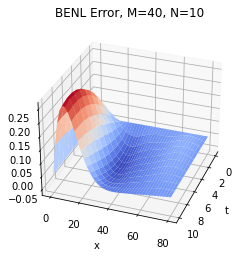

In [68]:
#%% Error testing of BE
M = 40
N = 10

t1 = time.time()
x, t, U = BENLBC1(R, T, M, N, sig1Sq, sig2Sq, c, K, H, exactInit, RHS = exRHS)


ex = getEx(x, t, M, N)
print(f"Total t = {time.time() - t1}")

az = 20
#plot_solution(x, t, U, txt=f"IMEX, M={M}, N={N}", azim=az)
#plot_solution(x, t, ex, txt=f"Exact, M={M}, N={N}", azim=az)

plot_solution(x, t, U - ex, txt=f"BENL Error, M={M}, N={N}", azim=az)
plt.show()

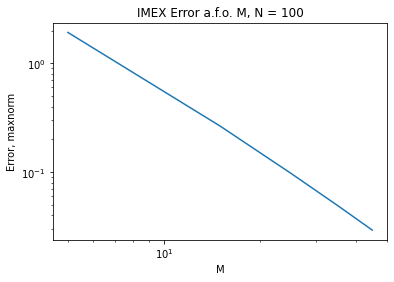

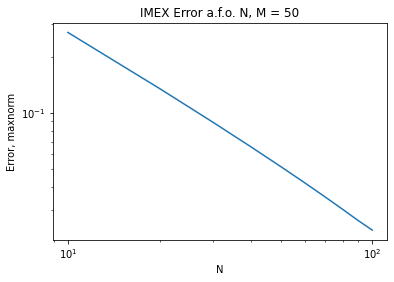

Slope when N varies: -1.062967595815034
Slope when M varies: -1.9050324959513232


In [70]:
errorAnalysisNonLin(BENLBC1, R, T, M, N, sig1Sq, sig2Sq, c, K, H, exactInit, RHS=exRHS, Nstart=10, Nstop=100, Nstep = 10
                  ,Mstart=5, Mstop=50)

Testing speed of the two methods given accuracy

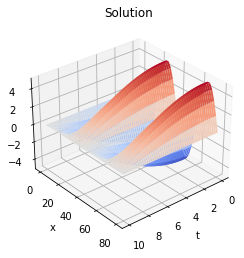

IMEX Err:0.04912095533699279 time: 0.08474373817443848


In [75]:
#%%1e) speed given accuracy, NL
# max error: 0.05
M = 35
N = 48

t1 = time.time()
x, t, U = IMEXBC1(R, T, M, N, sig1Sq, sig2Sq, c, K, H, exactInit, RHS = exRHS)
dt = time.time() - t1
plot_solution(x, t, U)

ex = getEx(x, t, M, N)
error = U - ex
err = np.abs(error).max()


Max error: 0.05.

Results from experimentation with the cell above:

BENL: M: 34, N: 47, dT: 0.300

IMEX: M: 35, N:48 dT: 0.01546
